In [31]:
import os, sys, time
import h5py
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn import Parameter
from torch.optim import lr_scheduler
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
batch_size = 64
num_epochs = 200
learning_rate = 0.01

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
path = "C:/Users/xiaomi/Documents/MobaXterm/home/testhaha/lrg_cont_spec_data"
files= os.listdir(path)
cont_flux =np.zeros(4500).reshape(1,4500)  #the continuum spectrum of objects, which is got through PCA template fit
for file in files[0:100]:
    with h5py.File(path+"/"+file, 'r') as f:
        for i in range(len(f['cont_flux'])):
            cont_flux =np.append(cont_flux,f['cont_flux'][i][0:4500].reshape(1,4500),axis=0)

y_scale=np.zeros(len(cont_flux)-1)
for i in range(10000):
    cont_flux[i+1][np.random.randint(1000,2000)]+=1.5
    y_scale[i]=1
X_scale=cont_flux[1:len(cont_flux)]
print(1)

Running on the GPU
1


### Global Parameters

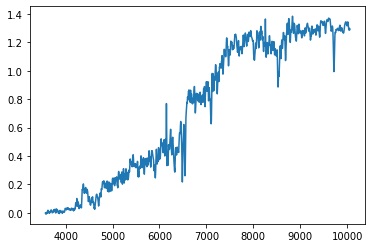

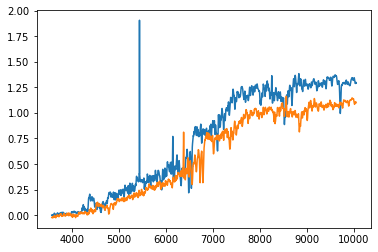

In [33]:
with h5py.File(path+"/"+files[0], 'r') as f:
    loglam = f['loglam'][()]
    cont=f['cont_flux'][()]
    
plt.plot(10**loglam[0:4500],cont[3][0:4500])
plt.show()

plt.plot(10**loglam[0:4500],X_scale[3,:])
plt.plot(10**loglam[0:4500],X_scale[10010,:])
plt.show()

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scale, y_scale, test_size=0.1, random_state=60)

#X_train=X_scale
#y_train=y_scale
# pass training set data to GPU
XT = torch.from_numpy(X_train).float()
XT = XT.view(len(XT), 1, -1)

print(XT.size())

YT = torch.from_numpy(y_train).long()
YT = torch.autograd.Variable(YT).view(len(YT), 1, -1)

print(YT.size())

# pass validation set data to GPU
XV= torch.from_numpy(X_valid).float()
XV= XV.view(len(XV), 1, -1)

YV= torch.from_numpy(y_valid).long()
YV= torch.autograd.Variable(YV).view(len(YV), 1, -1)


torch.Size([15908, 1, 4500])
torch.Size([15908, 1, 1])


### Visualize Data

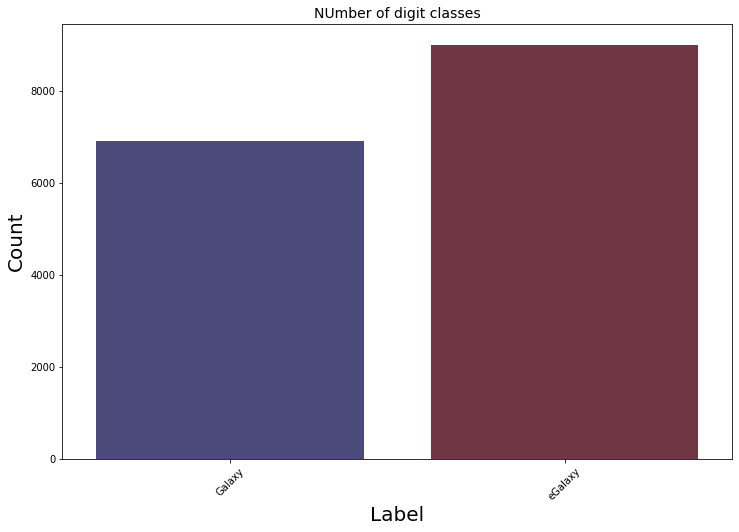

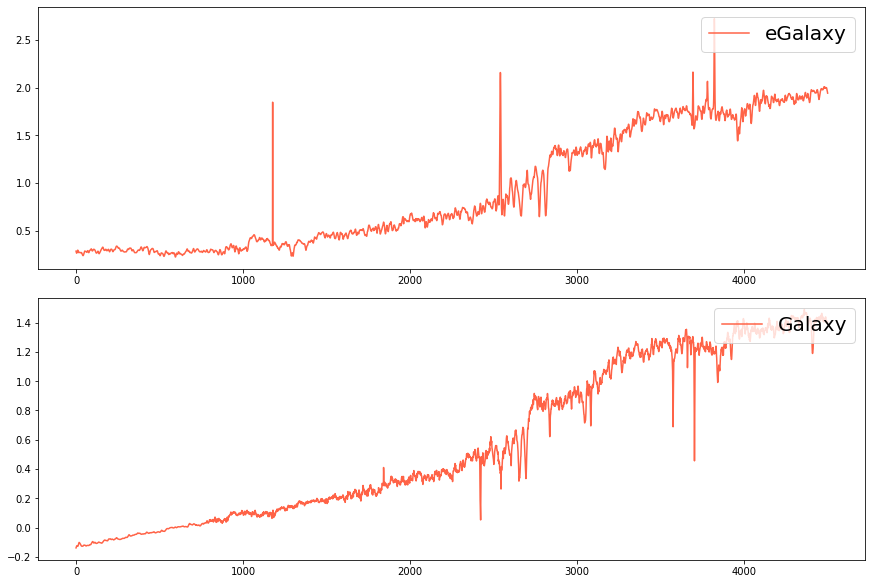

In [35]:
import pylab as pl
import seaborn as sns
pl.figure(figsize=(12, 8))
sns.countplot(y_train, palette = 'icefire')
pl.title('NUmber of digit classes', fontsize=14)
pl.xticks([0,1], ["Galaxy", "eGalaxy",], rotation='45')
pl.xlabel('Label', fontsize=20);
pl.ylabel('Count', fontsize=20);

fig, axs = pl.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

idxeGalaxy= y_train==1
idxGalaxy=y_train==0
    
axs.ravel()[0].plot(X_train[idxeGalaxy][0], label='eGalaxy', c='tomato')
axs.ravel()[0].legend(loc='upper right', fontsize=20);

axs.ravel()[1].plot(X_train[idxGalaxy][0], label='Galaxy', c='tomato')
axs.ravel()[1].legend(loc='upper right', fontsize=20);

In [36]:
class RNN(nn.Module):
    def __init__(self, 
                 input_size=4500, 
                 hidden_size=128, 
                 num_layers=3, 
                 num_classes=3, 
                 device="cuda"):
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)


def trainFunc():
    permutation = torch.randperm(XT.size()[0])
    model.train()
    for i in range(0, XT.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = XT[indices], YT[indices].squeeze()
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epochs, loss.item()))
    
    return loss.item()
    
def validFunc():
    model.eval()    
    permutation = torch.randperm(XV.size()[0])
    for i in range(0, XV.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = XV[indices], YV[indices].squeeze()
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
    return loss.item()
        
# loop the processes of training and validation    
TRN_LOSSES = []
VLD_LOSSES = []

for epoch in range(num_epochs):
    TLtmp = trainFunc()
    VLtmp = validFunc()
    scheduler.step(VLtmp)    
    TRN_LOSSES.append(TLtmp)
    VLD_LOSSES.append(VLtmp)
    
    torch.save(model.state_dict(), "C:/Users/xiaomi/Desktop/spec/spectrumClassification/outputs/spectrum/models/"+str(epoch)+"-lstm.pt")

Epoch [10/200], Loss: 0.6893
Epoch    16: reducing learning rate of group 0 to 1.0000e-03.
Epoch [20/200], Loss: 0.6796
Epoch [30/200], Loss: 0.6876
Epoch    37: reducing learning rate of group 0 to 1.0000e-04.
Epoch [40/200], Loss: 0.6948
Epoch    48: reducing learning rate of group 0 to 1.0000e-05.
Epoch [50/200], Loss: 0.6872
Epoch    59: reducing learning rate of group 0 to 1.0000e-06.
Epoch [60/200], Loss: 0.6872
Epoch [70/200], Loss: 0.6798
Epoch    70: reducing learning rate of group 0 to 1.0000e-07.
Epoch [80/200], Loss: 0.7091
Epoch    81: reducing learning rate of group 0 to 1.0000e-08.
Epoch [90/200], Loss: 0.6945
Epoch [100/200], Loss: 0.7091
Epoch [110/200], Loss: 0.6945
Epoch [120/200], Loss: 0.6798
Epoch [130/200], Loss: 0.7018
Epoch [140/200], Loss: 0.7018
Epoch [150/200], Loss: 0.6579
Epoch [160/200], Loss: 0.6725
Epoch [170/200], Loss: 0.6652
Epoch [180/200], Loss: 0.6725
Epoch [190/200], Loss: 0.6945
Epoch [200/200], Loss: 0.6798


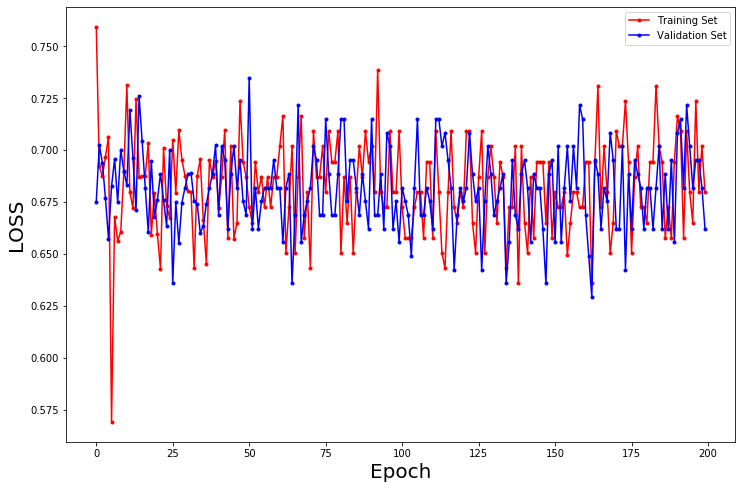

In [41]:

# plot the losses of training and validation sets across the epochs
pl.figure(figsize=(12,8))
pl.plot(TRN_LOSSES, 'r.-', label="Training Set")
pl.plot(VLD_LOSSES, 'b.-', label='Validation Set')
pl.xlabel("Epoch", fontsize=20)
pl.ylabel("LOSS", fontsize=20)
pl.legend()